# Combining the 2020 Election Models

Pulling together predictions for the presidential, Senate, House, governor and state legislature races in 2020 to find places that are especially powerful this election cycle. 

In [1]:
import os
import json
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use('seaborn-whitegrid')
#sns.set_style('whitegrid', {'text.color:': '0'}) #.05

## Helper functions

In [2]:
def normed_prob(a, bounds, interval=[0.475, 0.525]): #0.475,0.525 #0.49,0.51
    # Normalize data over [0,1]
    a = (a - bounds[0]) / (bounds[1] - bounds[0])
    # Integrate over interval
    # inbounds = a[(a > interval[0]) & (a < interval[1])]
    # return len(inbounds)/len(a)
    # Use kde instead, avoids threshold problem with discrete data
    kde = stats.gaussian_kde(a)
    return kde.integrate_box_1d(interval[0], interval[1])

def plot_histogram(sims, mean_outcome, midpoint, title, x_label, bins=None, out=None):
    fig, ax = plt.subplots(figsize=[6, 4])
    if bins:
        #kde=False, norm_hist=False
        sns.distplot(sims, ax=ax, bins=bins) 
    else:
        sns.distplot(sims, ax=ax)
    #ax.grid(alpha=0.5)
    ax.axvline(mean_outcome, color='red', alpha=0.9)
    ax.axvline(midpoint, color='gray')
    ax.set_title(title)
    ax.set_xlabel(x_label)
    if out:
        plt.savefig('data/output/{}'.format(out), bbox_inches='tight') #bbox_inches='tight'
    return ax

def seatplot(plot_df, x, y, title, x_label, figsize=[6, 11], xlim=[0.2, 0.8], out=None):
    # https://matplotlib.org/3.1.1/gallery/statistics/errorbar_features.html
    # https://stackoverflow.com/questions/31081568
    fig, ax = plt.subplots(figsize=figsize)
    ax.errorbar(
        x=plot_df[x],
        y=plot_df.index,
        xerr=np.array(plot_df[['lower', 'upper']]).T,
        fmt='.' #b
    ) # alpha=0.7 color='cornflowerblue' color='royalblue'  alpha=0.8
    plt.yticks(ticks=plot_df.index, labels=plot_df[y])
    ax.grid(alpha=0.6)
    ax.axvline(0.5, color='gray', alpha=0.9)
    ax.set_xlabel(x_label)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    plt.title(title)
    if out:
        plt.savefig('data/output/{}'.format(out), bbox_inches='tight') #bbox_inches='tight' , quality=95
    return ax

# Power sharing model

In [3]:
state_metadata = pd.read_csv('data/state_metadata.csv')
state_metadata.head()

,fips,state_abbr,state_name,pop_2018,electoral_votes_2016
0,1,AL,Alabama,4887871,9
1,2,AK,Alaska,737438,3
2,4,AZ,Arizona,7171646,11
3,5,AR,Arkansas,3013825,6
4,6,CA,California,39557045,55


In [4]:
stateleg_metadata = pd.read_csv('data/state_legislature_metadata.csv')
stateleg_metadata.head()

,senate_num,senate_term,house_num,house_term,state_abbr
0,35,4,105.0,4.0,AL
1,20,4,40.0,2.0,AK
2,30,2,60.0,2.0,AZ
3,35,4,100.0,2.0,AR
4,40,4,80.0,2.0,CA


In [5]:
total_power = 100

federal_power = 0.5*total_power
presidential_power = 0.5*federal_power
senate_power = 0.25*federal_power
house_power = 0.25*federal_power

states_power = 0.5*total_power
governor_power = 0.5*states_power
state_senate_power = 0.25*states_power
state_house_power = 0.25*states_power

In [6]:
# Calculate state government power values based on fraction of national population
state_power = state_metadata.copy()
state_power['multiplier'] = state_power['pop_2018']/state_power['pop_2018'].sum()
state_power['governor_power'] = governor_power*state_power['multiplier']
state_power['state_senate_power'] = state_senate_power*state_power['multiplier']
state_power['state_house_power'] = state_house_power*state_power['multiplier']
state_power.drop(['electoral_votes_2016', 'pop_2018', 'multiplier'], axis='columns', inplace=True)
state_power.head()

,fips,state_abbr,state_name,governor_power,state_senate_power,state_house_power
0,1,AL,Alabama,0.373499,0.186750,0.186750
1,2,AK,Alaska,0.056350,0.028175,0.028175
2,4,AZ,Arizona,0.548010,0.274005,0.274005
3,5,AR,Arkansas,0.230297,0.115148,0.115148
4,6,CA,California,3.022691,1.511346,1.511346


# Categorical rating conversions

Fivethirtyeight mentions an analysis [here](https://fivethirtyeight.com/features/2018-house-forecast-methodology/) that estimates the average margin of victory for different expert rating categories. I then use these to quantify expert ratings for governor ([Inside Elections](http://www.insideelections.com/ratings/governor)) and state legislatures ([CNalysis](https://www.cnalysiscom.website/)) below.

| Expert Rating | Average margin of victory |
| --- | --- |
| Toss-up | 0 points |
| “Tilts” toward candidate | 4 points |
| “Leans” toward candidate | 7 points |
| “Likely” for candidate | 12 points |
| “Solid” or “safe” for candidate | 34 points |

In [7]:
rating_categories = pd.DataFrame.from_dict({
    'inside_elections': ['currently-safe-democrat', 'democrat-favored', 'lean-democrat', 
        'toss-up-tilt-democrat', 'pure-toss-up', 'toss-up-tilt-republican',
        'lean-republican', 'republican-favored', 'currently-safe-republican'],
    'cnalysis': ['Safe D', 'Likely D', 'Lean D', 'Tilt D', 'Toss-Up', 
        'Tilt R', 'Lean R', 'Likely R', 'Safe R'],
    'dem_margin': [0.34, 0.12, 0.07, 0.04, 0, -0.04, -0.07, -0.12, -0.34]
})

rating_categories

,inside_elections,cnalysis,dem_margin
0,currently-safe-democrat,Safe D,0.34
1,democrat-favored,Likely D,0.12
2,lean-democrat,Lean D,0.07
3,toss-up-tilt-democrat,Tilt D,0.04
4,pure-toss-up,Toss-Up,0.00
5,toss-up-tilt-republican,Tilt R,-0.04
6,lean-republican,Lean R,-0.07
7,republican-favored,Likely R,-0.12
8,currently-safe-republican,Safe R,-0.34


# President

Using the Economist's presidential [model](https://projects.economist.com/us-2020-forecast/president) outputs to calculate the probability of a close election and the tipping point probability by state.

In [8]:
ec = pd.read_csv('data/president/economist_electoral_college_simulations.csv')
ec.head()

,draw,dem_ev,natl_pop_vote,AK,AL,AR,AZ,CA,CO,CT,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,1,412,0.543788,0.4925,0.4195,0.3990,0.5126,0.6453,0.5476,0.5974,...,0.4549,0.4454,0.5067,0.4115,0.5490,0.6916,0.6267,0.5582,0.3689,0.3166
1,2,397,0.554350,0.4809,0.3902,0.3774,0.5287,0.7100,0.5619,0.6557,...,0.4185,0.4245,0.5173,0.4517,0.5657,0.6960,0.6457,0.5451,0.3667,0.3017
2,3,374,0.561801,0.4921,0.4157,0.4351,0.5240,0.6658,0.5955,0.6396,...,0.4278,0.4450,0.4784,0.4427,0.5919,0.6760,0.6526,0.5594,0.4043,0.3347
3,4,394,0.553816,0.4749,0.4077,0.3808,0.5254,0.6683,0.5474,0.6382,...,0.4372,0.4237,0.5034,0.4108,0.5751,0.7037,0.6138,0.5617,0.3823,0.3152
4,5,378,0.543376,0.4759,0.4013,0.3592,0.5329,0.6688,0.5857,0.6195,...,0.4234,0.4026,0.5113,0.4392,0.5393,0.6889,0.6452,0.5439,0.3442,0.3058


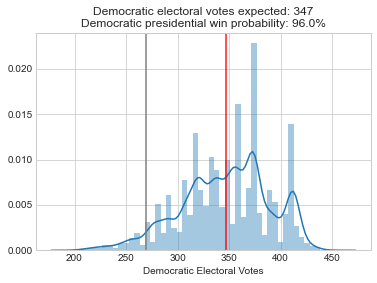

In [9]:
ec_ev_exp = ec['dem_ev'].mean()
ec_dem_win_prob = np.round(((ec['dem_ev'] >= 269).sum()/len(ec))*100, decimals=1)
ec_prob_close = normed_prob(ec['dem_ev'], bounds=[0, 538]) #interval=[0.475, 0.525]
ec_title = 'Democratic electoral votes expected: {0}\nDemocratic presidential win probability: {1}%'\
    .format(round(ec_ev_exp), ec_dem_win_prob)
plot_histogram(ec['dem_ev'], ec_ev_exp, 269, ec_title,
    out='presidentialhist.png', x_label='Democratic Electoral Votes')
plt.show()

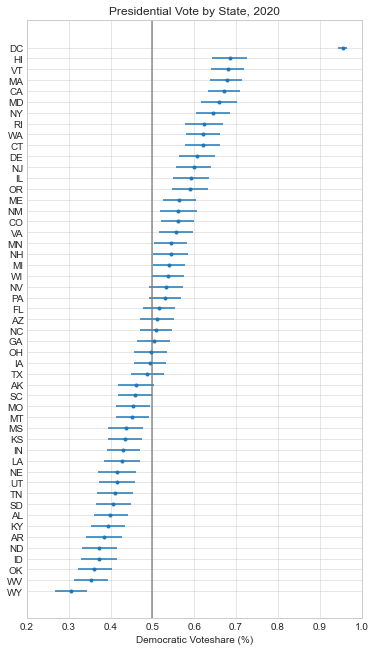

In [10]:
pres_states = pd.read_csv('data/president/economist_state_averages_and_predictions_topline.csv')
pres_states['upper'] = pres_states['projected_vote_high'] - pres_states['projected_vote_mean']
pres_states['lower'] = pres_states['projected_vote_mean'] - pres_states['projected_vote_low']
pres_states = pres_states.sort_values(by='projected_vote_mean', ascending=True).reset_index()
seatplot(pres_states, x='projected_vote_mean', x_label='Democratic Voteshare (%)',
    y='state', title='Presidential Vote by State, 2020', out='presidentialstates.png',
    xlim=[0.2,1.0]) #.png .jpg

In [11]:
def presidential_tipping_point(ec):
    '''Find tipping point state for each simulation, return dataframe
    including tipping probability.'''
    
    votes = ec.loc[:,'AK':'WY'].T
    ev = state_metadata[['state_abbr', 'electoral_votes_2016']].copy()
    ev.rename(columns={'electoral_votes_2016': 'ev'}, inplace=True)
    ev.set_index('state_abbr', inplace=True)
    tip_states = []

    for col in votes.columns:
        a = votes[col]
        onesim = pd.concat([ev, a], axis=1)
        onesim.rename(columns={col:'dem'}, inplace=True)
        onesim['win'] = (onesim['dem'] > 0.5)
        dem_ev = (onesim['ev']*onesim['win']).sum()
        #if abs(269-dem_ev) < 0.05*269:
        #if abs(269-dem_ev) < 100: #55
        #if dem_ev >= 269: #greater equal, or greater? 
        if dem_ev + np.random.choice([0,1]) > 269: #Half time give tie win to D/R
            onesim.sort_values(by='dem', ascending=False, inplace=True)
        else:
            onesim.sort_values(by='dem', ascending=True, inplace=True)
        onesim['evsum'] = onesim['ev'].cumsum()
        tip_state = onesim[onesim['evsum'] >= 269].head(1).index[0]
        tip_states.append(tip_state)
    
    tp = pd.DataFrame.from_dict({'state':tip_states, 'count': 1})
    tp = tp.groupby(by='state').agg({'count':'sum'})
    tp['pr_tip'] = tp['count']/tp['count'].sum()
    del tp['count']
    return tp

def get_presidential_power(tp, presidential_power, ec_prob_close, state_metadata):
    '''Calculate presidential power by state using baseline power value,
    the probability of a close election, and thetipping point probability'''
    
    tp['realized_power'] = presidential_power*ec_prob_close*tp['pr_tip']
    tp.reset_index(drop=False, inplace=True)
    missing_states = state_metadata[~state_metadata['state_abbr'].isin(tp.state)]['state_abbr']
    missing = pd.DataFrame.from_dict({
        'state': missing_states,
        'pr_tip': 0,
        'realized_power': 0
    })
    cols = ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    pres_power_df = pd.concat([tp, missing])
    pres_power_df[['office', 'district', 'potential_power', 'pr_close']] = \
        ['president', None, presidential_power, ec_prob_close]
    pres_power_df = pres_power_df[cols]
    pres_power_df.sort_values(by='realized_power', ascending=False, inplace=True)
    return pres_power_df

In [12]:
pres_tipping_states = presidential_tipping_point(ec)
#pres_tipping_states.sort_values(by='pr_tip', ascending=False).head(50)

In [13]:
pres_power_df = get_presidential_power(pres_tipping_states, presidential_power,
    ec_prob_close, state_metadata)
pres_power_df.head()

,state,office,district,potential_power,pr_close,pr_tip,realized_power
15,PA,president,None,25.0,0.056679,0.425938,0.603546
2,FL,president,None,25.0,0.056679,0.106688,0.151174
7,MI,president,None,25.0,0.056679,0.096687,0.137005
18,WI,president,None,25.0,0.056679,0.080187,0.113624
0,AZ,president,None,25.0,0.056679,0.043187,0.061196


# US Senate

Using Cory McCartan's model [here](https://corymccartan.github.io/projects/senate-20/), which produces results that estimate the tipping probability of each Senate seat. He also includes simulation outputs that I use to calculate the probability of a close election.

In [14]:
with open('data/senate/mccartan_senate.json') as f:
    mc = json.load(f)

mc_df = pd.DataFrame(mc['races'])
mc_df.sort_values(by='tipping_pt', ascending=False).head(5)

,race,race_name,prob,dem_q05,dem_q25,dem_exp,dem_q75,dem_q95,recount,tipping_pt,votes,pr_decisive,rel_voter_power,inc
3,AZ,Arizona,0.652667,0.447248,0.488111,0.516610,0.542263,0.580105,0,0.086376,2216736.00,3.896540e-08,1.429618,-1
15,ME,Maine,0.660000,0.450896,0.488285,0.517531,0.547468,0.585638,0,0.085772,675138.75,1.270435e-07,4.661154,-1
20,NC,North Carolina,0.622667,0.450084,0.484927,0.512358,0.539472,0.575247,0,0.085755,3634615.75,2.359387e-08,0.865646,-1
6,GA,Georgia,0.678667,0.452298,0.491497,0.518010,0.545045,0.582987,0,0.085213,3193538.25,2.668305e-08,0.978986,-1
7,GA-S,Georgia-S,0.548000,0.438820,0.478060,0.506564,0.534487,0.575552,0,0.076251,3193538.25,2.387655e-08,0.876017,-1


In [15]:
# hm
# mc_df['tipping_pt'].sum()
# 2.0000003
# mc_df['tipping_pt'] = mc_df['tipping_pt']/2
mc_df['tipping_pt'].sum()

1.0000002000000001

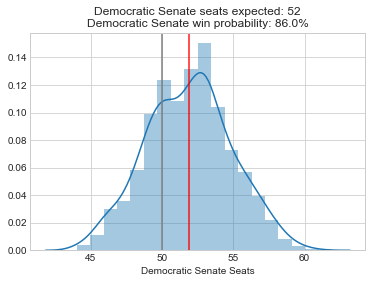

In [16]:
# Load all simulation results
with open('data/senate/mccartan_senate_sim.json') as f:
    mc_sim = json.load(f)
# Add number of Dem wins in each simulation to current
# uncontested control of 35 seats
mc_sim = np.array([sum(x['dem']) + 35 for x in mc_sim])
mc_pr_close = normed_prob(mc_sim, bounds=[0,100]) #interval=[0.475, 0.525]
#mc_dem_win = (mc_sim >= 50).sum()/len(mc_sim) #>=50 = 79%, >50 = 69.3
# Just use his probability, it incorporates presidential tie breaker probability
# https://github.com/CoryMcCartan/senate/blob/master/model/forecast.R#L313
mc_dem_win = mc['prob']
mc_dem_seats = np.mean(mc_sim)
mc_title = 'Democratic Senate seats expected: {0}\nDemocratic Senate win probability: {1}%'\
    .format(round(mc_dem_seats), np.round(mc_dem_win*100, 1))
mc_bins = (max(mc_sim)-min(mc_sim) + 1)
plot_histogram(mc_sim, mc_dem_seats, 50, mc_title,
    x_label='Democratic Senate Seats', bins=mc_bins,
    out='senatehist.png')

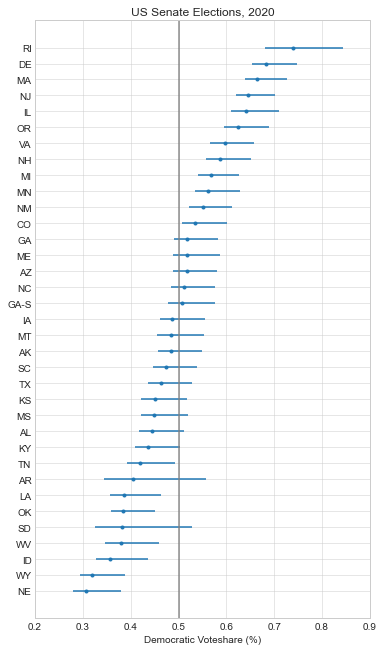

In [17]:
mc_plot = mc_df.copy()
mc_plot['upper'] = mc_plot['dem_q95'] - mc_plot['dem_exp']
mc_plot['lower'] = mc_plot['dem_exp'] - mc_plot['dem_q25']
mc_plot = mc_plot.sort_values(by='dem_exp', ascending=True).reset_index()
seatplot(mc_plot, x='dem_exp', x_label='Democratic Voteshare (%)', 
    y='race', title='US Senate Elections, 2020', out='senateseats.png',
    xlim=[0.2,0.9])

In [18]:
def get_senate_power(mc_df, senate_power, mc_pr_close):
    senate_power_df = mc_df[['race', 'tipping_pt']].copy()
    senate_power_df.rename(
        columns={'race': 'state', 'tipping_pt': 'pr_tip'},
        inplace=True
    )
    senate_power_df['office'] = 'ussenate'
    senate_power_df['potential_power'] = senate_power
    senate_power_df['district'] = senate_power_df['state']
    # Rename GA-S to GA, special senate race from there
    senate_power_df['state'].replace({'GA-S':'GA'}, inplace=True, regex=True)
    senate_power_df['pr_close'] = mc_pr_close
    senate_power_df['realized_power'] = senate_power*mc_pr_close*senate_power_df['pr_tip']
    senate_power_df = senate_power_df[
        ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    ]
    senate_power_df.sort_values(by='realized_power', ascending=False, inplace=True)
    return senate_power_df

In [19]:
senate_power_df = get_senate_power(mc_df, senate_power, mc_pr_close)
senate_power_df.head(10)

,state,office,district,potential_power,pr_close,pr_tip,realized_power
3,AZ,ussenate,AZ,12.5,0.490034,0.086376,0.529090
15,ME,ussenate,ME,12.5,0.490034,0.085772,0.525390
20,NC,ussenate,NC,12.5,0.490034,0.085755,0.525284
6,GA,ussenate,GA,12.5,0.490034,0.085213,0.521968
7,GA,ussenate,GA-S,12.5,0.490034,0.076251,0.467068
8,IA,ussenate,IA,12.5,0.490034,0.075932,0.465116
19,MT,ussenate,MT,12.5,0.490034,0.073619,0.450946
0,AK,ussenate,AK,12.5,0.490034,0.063060,0.386270
4,CO,ussenate,CO,12.5,0.490034,0.061088,0.374190
28,SC,ussenate,SC,12.5,0.490034,0.046103,0.282399


# US House

Using Inside Election's House seat [ratings](https://insideelections.com/ratings/house) in place of a polling average, which I then sample around using normal distributions.


In [20]:
house_data = pd.read_csv('data/house/inside_elections_house.csv')
house_data = house_data.merge(
    rating_categories[['inside_elections', 'dem_margin']],
    left_on='rating', right_on='inside_elections'
)

house_data['dem'] = 0.50+0.5*house_data['dem_margin']
house_data.head()

,state,district,party,rating,inside_elections,dem_margin,dem
0,AL,1,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
1,AL,2,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
2,AL,3,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
3,AL,4,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33
4,AL,5,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.33


In [21]:
def simulate_house(n, state_uncertainty_sd, national_uncertainty_sd, house_data): 
    seats = house_data[['state', 'district']]
    sims = []
    dem_seats = []
    tip_seats = []
    summary = []

    for i in range(n):
        # Account for potential national swing
        national_error = np.random.normal(0, national_uncertainty_sd)
        
        onesim = house_data[['state', 'district', 'dem']].copy()
        onesim['sample'] = np.random.normal(onesim['dem'], state_uncertainty_sd) + national_error
        dem_sim_seats = (onesim['sample'] > 0.5).sum()
        sims.append(onesim['sample'])
        dem_seats.append(dem_sim_seats)
        # Find tipping point seat
        #if abs(dem_sim_seats - 217.5) < 40: # Limit to close races?
        if dem_sim_seats >= 218:
            onesim = onesim.sort_values(by='sample', ascending=False)
        else:
            onesim = onesim.sort_values(by='sample', ascending=True)
        onesim.reset_index(drop=True, inplace=True)
        tip_seats.append(list(onesim.loc[218][['state', 'district']]))
    
    # Process simulation results to get seat statistics
    sims = np.array(sims)
    seat_sims = sims.T
    for i, seat in enumerate(seats.itertuples()):
        this_sim = seat_sims[i]
        mean_vote = np.mean(this_sim)
        quantile = np.quantile(this_sim, [0.025, 0.975])
        summary.append({'state': getattr(seat,'state'), 'district': getattr(seat, 'district'), 
            'mean_vote': mean_vote, 'q_025': quantile[0], 'q_975': quantile[1]})
            
    return {'seats': seats, 'sims': sims, 'dem_seats': dem_seats,
        'tip_seats': tip_seats, 'summary': summary}

def get_house_power(house_results, house_power, house_prob_close):
    house_tip = pd.DataFrame(
        columns=['state', 'district'], 
        data=house_results['tip_seats']
    )
    house_tip['count'] = 1
    house_tip = house_tip.groupby(by=['state', 'district']).agg({'count': 'sum'})
    house_tip['pr_tip'] = house_tip['count']/house_tip['count'].sum()
    house_tip['realized_power'] = house_power*house_prob_close*house_tip['pr_tip']
    house_tip.reset_index(drop=False, inplace=True)
    del house_tip['count']
    #house_tip.sort_values(by='realized_power', ascending=False).head(30)

    missing = house_data[['state', 'district']]
    house_power_df = missing.merge(house_tip, on=['state', 'district'], how='outer')
    house_power_df.fillna(value=0, inplace=True)
    cols = ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    house_power_df[['office', 'potential_power', 'pr_close']] = \
        ['ushouse', house_power, house_prob_close]
    house_power_df = house_power_df[cols]
    house_power_df.sort_values(by='realized_power', ascending=False, inplace=True)
    return house_power_df

In [22]:
house_results = simulate_house(n=10000, state_uncertainty_sd=0.05, 
    national_uncertainty_sd=0.03, house_data=house_data)
house_summary = pd.DataFrame.from_dict(house_results['summary'])
house_summary

,state,district,mean_vote,q_025,q_975
0,AL,1,0.329942,0.217982,0.443630
1,AL,2,0.330907,0.215705,0.444687
2,AL,3,0.329536,0.215273,0.444000
3,AL,4,0.330168,0.216249,0.443478
4,AL,5,0.329772,0.215850,0.442880
...,...,...,...,...,...
430,OH,1,0.520159,0.407173,0.635379
431,TX,23,0.519472,0.405908,0.633936
432,TX,24,0.520398,0.407549,0.634147
433,UT,4,0.520598,0.405824,0.634834


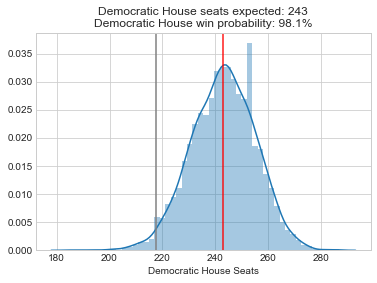

In [23]:
house_sims = np.array(house_results['dem_seats'])
house_mean_seats = house_sims.mean()
house_win_prob = (house_sims >= 218).sum()/len(house_sims)
house_prob_close = normed_prob(house_sims, bounds=[0,435])
house_title = 'Democratic House seats expected: {0}\nDemocratic House win probability: {1}%'\
    .format(round(house_mean_seats), np.round(house_win_prob*100, 1))
plot_histogram(house_sims, house_mean_seats, 217.5, house_title,
    x_label='Democratic House Seats', out='househist.png')

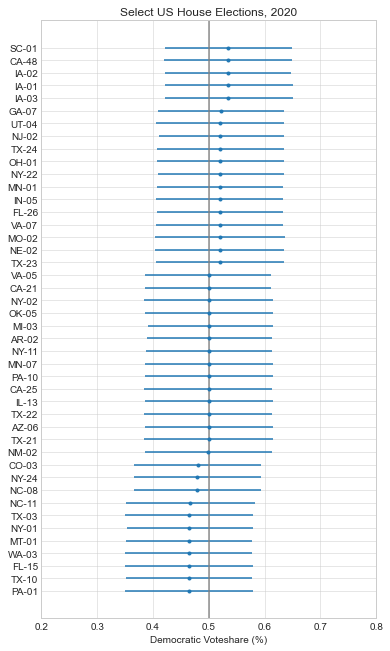

In [24]:
houseplot_df = house_summary.copy()
houseplot_df['upper'] = houseplot_df['q_975'] - houseplot_df['mean_vote']
houseplot_df['lower'] = houseplot_df['mean_vote'] - houseplot_df['q_025']
houseplot_df = houseplot_df[
    (houseplot_df['mean_vote'] > 0.45) &
    (houseplot_df['mean_vote'] < 0.55)
]
houseplot_df['label'] = houseplot_df['state'] + '-' + houseplot_df['district'].astype(str).str.zfill(2)
houseplot_df = houseplot_df.sort_values(by='mean_vote', ascending=True).reset_index()
seatplot(houseplot_df, x='mean_vote', y='label', title='Select US House Elections, 2020',
    x_label='Democratic Voteshare (%)', xlim=[0.2, 0.8],
    out='houseseats.png') #figsize=[6,12.5]

In [25]:
house_power_df = get_house_power(house_results, house_power, house_prob_close)
house_power_df.head(10)

,state,office,district,potential_power,pr_close,pr_tip,realized_power
388,OR,ushouse,4,12.5,0.113734,0.0213,0.030282
387,NC,ushouse,6,12.5,0.113734,0.0206,0.029287
382,GA,ushouse,6,12.5,0.113734,0.0200,0.028434
406,CA,ushouse,48,12.5,0.113734,0.0200,0.028434
385,NJ,ushouse,7,12.5,0.113734,0.0199,0.028291
408,IA,ushouse,2,12.5,0.113734,0.0189,0.026870
389,TX,ushouse,7,12.5,0.113734,0.0186,0.026443
381,CA,ushouse,39,12.5,0.113734,0.0180,0.025590
380,AZ,ushouse,1,12.5,0.113734,0.0177,0.025164
383,NV,ushouse,3,12.5,0.113734,0.0175,0.024879


# Governors

Use Inside Election's governors [ratings](https://insideelections.com/ratings/governor) as a polling average to sample around. 

In [26]:
gov_data = pd.read_csv('data/governor/inside_elections_gov.csv')
gov_data = gov_data.merge(
    rating_categories[['inside_elections', 'dem_margin']],
    left_on='rating', right_on='inside_elections'
)

gov_data['dem'] = 0.50+0.5*gov_data['dem_margin']
gov_data

,state,party,rating,inside_elections,dem_margin,dem
0,DE,Democrat,currently-safe-democrat,currently-safe-democrat,0.34,0.670
1,WA,Democrat,currently-safe-democrat,currently-safe-democrat,0.34,0.670
2,IN,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
3,ND,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
4,UT,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
5,VT,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
6,WV,Republican,currently-safe-republican,currently-safe-republican,-0.34,0.330
7,MO,Republican,lean-republican,lean-republican,-0.07,0.465
8,MT,Democrat,pure-toss-up,pure-toss-up,0.00,0.500
9,NH,Republican,republican-favored,republican-favored,-0.12,0.440


In [27]:
def simulate_governors(n, state_uncertainty_sd, national_uncertainty_sd, govs): 
    seats = govs['state']
    votes = []

    for i in range(n):
        # Account for potential national swing
        national_error = np.random.normal(0, national_uncertainty_sd)
        
        # Only need to sample from seat, adding in national swing
        sample = np.random.normal(govs['dem'], state_uncertainty_sd) + national_error
        votes.append(sample)
    
    # Process simulation results to get seat statistics
    state_votes = np.array(votes).T
    summary = []
    for n, seat in enumerate(seats):
        seat_votes = state_votes[n]
        mean_vote = np.mean(seat_votes)
        pr_close = normed_prob(seat_votes, bounds=[0,1])
        quantile = np.quantile(seat_votes, [0.025, 0.975])
        summary.append({'state': seat, 'pr_close': pr_close, 'mean_vote': mean_vote,
            'q_025': quantile[0], 'q_975': quantile[1]})

    return {'seats': seats, 'votes': votes, 'summary': summary}

def get_governor_power(gov_power_df, state_power):
    cols = ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    gov_seat_power = state_power[['state_abbr', 'governor_power']].copy()
    gov_seat_power.rename(
        columns={'state_abbr': 'state', 'governor_power': 'potential_power'}, 
        inplace=True
    )
    gov_power_df = gov_power_df.merge(gov_seat_power, on='state')
    gov_power_df['realized_power'] = gov_power_df['pr_close']*gov_power_df['potential_power']
    gov_power_df[['pr_tip', 'office', 'district']] = [1, 'governor', None]
    gov_power_df = gov_power_df[cols]
    gov_power_df.sort_values(by='realized_power', ascending=False, inplace=True)
    return gov_power_df

In [28]:
gov_results = simulate_governors(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, govs=gov_data)
gov_summary = pd.DataFrame.from_dict(gov_results['summary'])
gov_summary

,state,pr_close,mean_vote,q_025,q_975
0,DE,0.006547,0.670609,0.554870,0.784647
1,WA,0.006364,0.671305,0.556788,0.784467
2,IN,0.007124,0.330716,0.216939,0.442090
3,ND,0.006894,0.329844,0.217556,0.443085
4,UT,0.008612,0.330637,0.214479,0.447467
5,VT,0.006210,0.330383,0.217320,0.444320
6,WV,0.005615,0.331191,0.217440,0.443159
7,MO,0.275548,0.465628,0.350989,0.579313
8,MT,0.328889,0.500607,0.385663,0.615098
9,NH,0.202059,0.440973,0.326585,0.556917


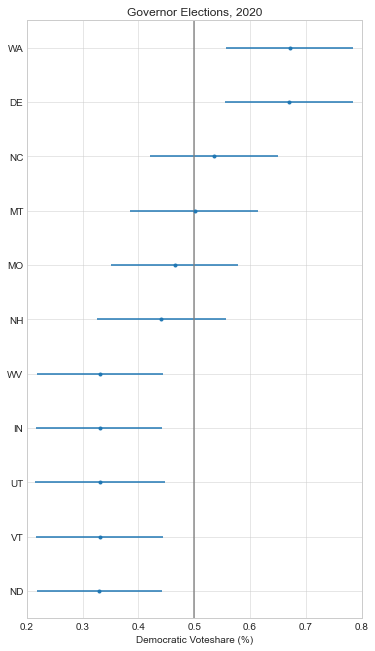

In [29]:
govplot_df = gov_summary.copy()
govplot_df['upper'] = govplot_df['q_975'] - govplot_df['mean_vote']
govplot_df['lower'] = govplot_df['mean_vote'] - govplot_df['q_025']
govplot_df = govplot_df.sort_values(by='mean_vote', ascending=True).reset_index()
seatplot(govplot_df, x='mean_vote', y='state', title='Governor Elections, 2020',
    x_label='Democratic Voteshare (%)', out='govseats.png')

In [30]:
gov_power_df = get_governor_power(gov_summary, state_power)
gov_power_df

,state,office,district,potential_power,pr_close,pr_tip,realized_power
10,NC,governor,None,0.793448,0.267726,1,0.212427
7,MO,governor,None,0.468143,0.275548,1,0.128996
8,MT,governor,None,0.081174,0.328889,1,0.026697
9,NH,governor,None,0.103652,0.202059,1,0.020944
1,WA,governor,None,0.575821,0.006364,1,0.003665
2,IN,governor,None,0.511350,0.007124,1,0.003643
4,UT,governor,None,0.241551,0.008612,1,0.002080
6,WV,governor,None,0.137990,0.005615,1,0.000775
0,DE,governor,None,0.073905,0.006547,1,0.000484
3,ND,governor,None,0.058080,0.006894,1,0.000400


# State Legislatures
## State Houses

I'm pulling the state legislature rankings from [CNalysis](https://www.cnalysiscom.website/) instead of modeling individual seats in each legislature. I convert the categorical ratings into expected seat margins, then sample around those seat margins using the polling uncertainties I use above (state_sd = 0.05, national_sd = 0.03), scaled to match the number of seats in each legislature. I then sample from normal distributions around the projected seat margins to find win probabilities and probabilities of close elections. This isn't very sophisticated, but it's better than nothing.

In [31]:
sh = pd.read_csv('data/statehouse/cnalysis_shodds.csv')
sh.columns = map(str.lower, sh.columns)
sh = sh[sh['rating'] != 'No Election']
sh = sh[['state', 'rating']]

sh = sh.merge(rating_categories[['cnalysis', 'dem_margin']],
    right_on = 'cnalysis', left_on = 'rating'
)
sh = sh.merge(stateleg_metadata[['state_abbr', 'house_num']],
    left_on = 'state',right_on = 'state_abbr'
)
sh['dem'] = sh['house_num']/2 + sh['house_num']*(sh['dem_margin']/2)
sh.head()

,state,rating,cnalysis,dem_margin,state_abbr,house_num,dem
0,AK,Tilt R,Tilt R,-0.04,AK,40.0,19.20
1,NC,Tilt R,Tilt R,-0.04,NC,120.0,57.60
2,PA,Tilt R,Tilt R,-0.04,PA,203.0,97.44
3,AZ,Lean D,Lean D,0.07,AZ,60.0,32.10
4,AR,Safe R,Safe R,-0.34,AR,100.0,33.00


In [32]:
def simulate_statehouses(n, state_uncertainty_sd, national_uncertainty_sd, house_data):
    '''Note: this simulates expected seat count,
    not expected democratic margin by state'''
    
    house_data = house_data.copy()
    seats = house_data['state']
    sims = []
    summary = []
    # Scale the uncertainty so it is in units of house seats
    house_data['scaled_sd'] = house_data['house_num']*state_uncertainty_sd

    for i in range(n):
        onesim = house_data[['state', 'house_num', 'dem', 'scaled_sd']].copy()
        # Account for potential national swing, but scale that swing to 
        # the number of seats in each state house
        national_error = np.random.normal(0, national_uncertainty_sd)*onesim['house_num']
        onesim['sample'] = np.random.normal(onesim['dem'], onesim['scaled_sd']) + national_error
        onesim['sample'] = np.round(onesim['sample']) # Make discrete? Valid? Doesn't seem valid,
        # the states with small number of discrete seats like AZ get a lot more probability cut
        # off from the pr_close interval this way. Not sure the solution, I should probably ask
        # on stats stackexchange. Current solution is to use KDE to integrate.
        sims.append(onesim['sample'])
    
    # Process simulation results to get seat statistics
    sims = np.array(sims)
    seat_sims = sims.T
    house_data.set_index('state', inplace=True)
    for i, seat in enumerate(seats):
        res = seat_sims[i]
        pr_close = normed_prob(res,
            bounds=[0, house_data.loc[seat, 'house_num']]
        ) #interval=[0.475, 0.525]
        mean_seats = np.mean(res)
        quantile = np.quantile(res, [0.025, 0.975])
        summary.append({'state': seat, 'pr_close': pr_close,
            'mean_seats': mean_seats, 'q_025': quantile[0], 'q_975': quantile[1]})
    
    return {'seats': seats, 'sims': sims, 'summary': summary}

def get_statehouse_power(statehouse_summary, state_power):
    sthspw = statehouse_summary[['state', 'pr_close']]
    sthspw = sthspw.merge(
        state_power[['state_abbr','state_house_power']].copy() \
            .rename(columns={'state_abbr':'state', 'state_house_power':'potential_power'})
    )
    sthspw['realized_power'] = sthspw['potential_power']*sthspw['pr_close']
    #sthspw[['office', 'district', 'offi']]
    sthspw.sort_values(by='realized_power', ascending=False, inplace=True)
    sthspw[['office', 'district', 'pr_tip']] = ['statehouse', None, 1]
    cols = ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    sthspw = sthspw[cols]
    return sthspw

In [33]:
statehouse_results = simulate_statehouses(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, house_data=sh)

In [34]:
statehouse_summary = pd.DataFrame(statehouse_results['summary'])
statehouse_summary.sort_values(by='pr_close', ascending=False)
statehouse_summary.reset_index(drop=True, inplace=True)
statehouse_summary.head()

,state,pr_close,mean_seats,q_025,q_975
0,AK,0.307027,19.2183,15.0,24.0
1,NC,0.307410,57.5812,44.0,72.0
2,PA,0.314984,97.5593,74.0,121.0
3,AZ,0.280660,32.0914,25.0,39.0
4,AR,0.008148,33.0789,22.0,45.0


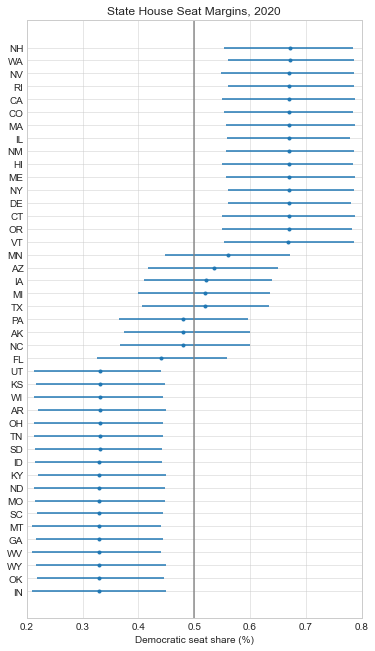

In [35]:
statehouse_plot = statehouse_summary.copy()
statehouse_plot = statehouse_plot.merge(
    stateleg_metadata[['state_abbr', 'house_num']],
    left_on='state', right_on='state_abbr'
)
#statehouse_plot.set_index('state', inplace=True)
# https://stackoverflow.com/questions/34540567
statehouse_plot[['mean_seats', 'q_025', 'q_975']] = statehouse_plot[['mean_seats', 'q_025', 'q_975']] \
    .div(statehouse_plot['house_num'], axis=0)
statehouse_plot['lower'] = statehouse_plot['mean_seats']-statehouse_plot['q_025']
statehouse_plot['upper'] = statehouse_plot['q_975']-statehouse_plot['mean_seats']
statehouse_plot.sort_values(by='mean_seats', ascending=True, inplace=True)
statehouse_plot.reset_index(drop=True, inplace=True)

seatplot(statehouse_plot, x='mean_seats', y='state', title='State House Seat Margins, 2020', 
         x_label='Democratic seat share (%)', out='statehouseseats.png')

In [36]:
statehouse_power_df = get_statehouse_power(statehouse_summary, state_power)
statehouse_power_df.head()

,state,office,district,potential_power,pr_close,pr_tip,realized_power
41,TX,statehouse,None,1.096604,0.308853,1,0.338689
38,FL,statehouse,None,0.813778,0.204026,1,0.166031
2,PA,statehouse,None,0.489316,0.314984,1,0.154127
1,NC,statehouse,None,0.396724,0.307410,1,0.121957
40,MI,statehouse,None,0.381911,0.308883,1,0.117966


# State Senates

Take same approach as with state houses above, getting the state senate ratings from CNalysis again.

In [37]:
ss = pd.read_csv('data/statesenate/cnalysis_ssodds.csv')
ss.columns = map(str.lower, ss.columns)
ss = ss[ss['rating'] != 'No Election']
ss = ss[['state', 'rating']]

ss = ss.merge(rating_categories[['cnalysis', 'dem_margin']],
    right_on = 'cnalysis', left_on = 'rating'
)
ss = ss.merge(stateleg_metadata[['state_abbr', 'senate_num']],
    left_on = 'state',right_on = 'state_abbr'
)
ss['dem'] = ss['senate_num']/2 + ss['senate_num']*(ss['dem_margin']/2)
ss.sort_values(by='dem_margin').head()

,state,rating,cnalysis,dem_margin,state_abbr,senate_num,dem
0,AK,Safe R,Safe R,-0.34,AK,20,6.60
20,WI,Safe R,Safe R,-0.34,WI,33,10.89
19,UT,Safe R,Safe R,-0.34,UT,29,9.57
18,TX,Safe R,Safe R,-0.34,TX,31,10.23
17,TN,Safe R,Safe R,-0.34,TN,33,10.89


In [38]:
def simulate_statesenates(n, state_uncertainty_sd, national_uncertainty_sd, senate_data):
    '''Note: this simulates expected seat count,
    not expected democratic margin by state.'''
    
    senate_data = senate_data.copy()
    states = senate_data['state']
    sims = []
    summary = []
    # Scale the uncertainty so it is in units of house seats
    senate_data['scaled_sd'] = senate_data['senate_num']*state_uncertainty_sd

    for i in range(n):
        onesim = senate_data[['state', 'senate_num', 'dem', 'scaled_sd']].copy()
        # Account for potential national swing, but scale that swing to 
        # the number of seats in each state senate
        national_error = np.random.normal(0, national_uncertainty_sd)*onesim['senate_num']
        onesim['sample'] = np.random.normal(onesim['dem'], onesim['scaled_sd']) + national_error
        onesim['sample'] = np.round(onesim['sample']) # Make discrete? Valid?
        sims.append(onesim['sample'])
    
    # Process simulation results to get seat statistics
    sims = np.array(sims)
    seat_sims = sims.T
    senate_data.set_index('state', inplace=True)
    for i, state in enumerate(states):
        res = seat_sims[i]
        pr_close = normed_prob(
            res,
            bounds=[0, senate_data.loc[state, 'senate_num']]
        ) #interval=[0.475, 0.525]
        mean_seats = np.mean(res)
        quantile = np.quantile(res, [0.025, 0.975])
        summary.append({'state': state, 'pr_close': pr_close,
            'mean_seats': mean_seats, 'q_025': quantile[0], 'q_975': quantile[1]})
    
    return {'seats': states, 'sims': sims, 'summary': summary}

def get_statesenate_power(summary, state_power):
    stspw = summary[['state', 'pr_close']].copy()
    stspw = stspw.merge(
        state_power[['state_abbr','state_senate_power']].copy() \
            .rename(columns={'state_abbr':'state', 'state_senate_power':'potential_power'})
    )
    stspw['realized_power'] = stspw['potential_power']*stspw['pr_close']
    #sthspw[['office', 'district', 'offi']]
    stspw.sort_values(by='realized_power', ascending=False, inplace=True)
    stspw[['office', 'district', 'pr_tip']] = ['statesenate', None, 1]
    cols = ['state', 'office', 'district', 'potential_power', 'pr_close', 'pr_tip', 'realized_power']
    stspw = stspw[cols]
    return stspw

In [39]:
statesenate_results = simulate_statesenates(n=10000, state_uncertainty_sd=0.05,
    national_uncertainty_sd=0.03, senate_data=ss)

In [40]:
statesenate_summary = pd.DataFrame(statesenate_results['summary'])
statesenate_summary.sort_values(by='pr_close', ascending=False).head()

,state,pr_close,mean_seats,q_025,q_975
40,NC,0.305008,23.9999,18.0,30.0
23,MN,0.281735,35.7822,28.0,43.0
42,WV,0.263956,15.8064,12.0,20.0
22,AZ,0.253107,16.0509,13.0,20.0
24,NH,0.245362,12.8427,10.0,16.0


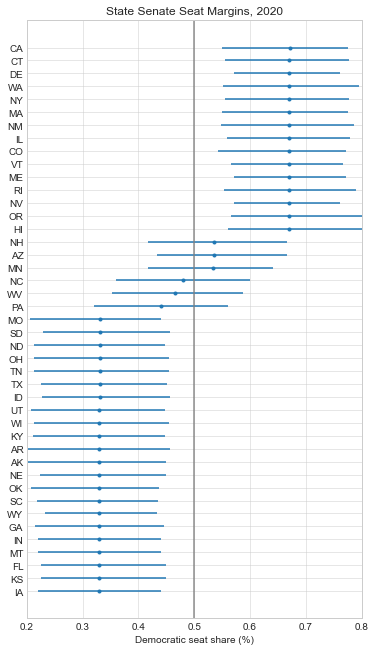

In [41]:
statesenate_plot = statesenate_summary.copy()
statesenate_plot = statesenate_plot.merge(
    stateleg_metadata[['state_abbr', 'senate_num']],
    left_on='state', right_on='state_abbr'
)
# https://stackoverflow.com/questions/34540567
statesenate_plot[['mean_seats', 'q_025', 'q_975']] = statesenate_plot[['mean_seats', 'q_025', 'q_975']] \
    .div(statesenate_plot['senate_num'], axis=0)
statesenate_plot['lower'] = statesenate_plot['mean_seats']-statesenate_plot['q_025']
statesenate_plot['upper'] = statesenate_plot['q_975']-statesenate_plot['mean_seats']
statesenate_plot.sort_values(by='mean_seats', ascending=True, inplace=True)
statesenate_plot.reset_index(drop=True, inplace=True)
seatplot(statesenate_plot, x='mean_seats', y='state',
    title='State Senate Seat Margins, 2020',
    x_label='Democratic seat share (%)', out='statesenateseats.png')

In [42]:
statesenate_power_df = get_statesenate_power(statesenate_summary, state_power)
statesenate_power_df.head()

,state,office,district,potential_power,pr_close,pr_tip,realized_power
40,NC,statesenate,None,0.396724,0.305008,1,0.121004
41,PA,statesenate,None,0.489316,0.203799,1,0.099722
22,AZ,statesenate,None,0.274005,0.253107,1,0.069353
23,MN,statesenate,None,0.214385,0.281735,1,0.060400
42,WV,statesenate,None,0.068995,0.263956,1,0.018212


# Cumulative Values

Concatenate all the power values together, and calculate summary statistics.

In [43]:
today = datetime.date.today()

cumulative_df = pd.concat([pres_power_df, senate_power_df, house_power_df,
    gov_power_df, statehouse_power_df, statesenate_power_df])
cumulative_df = cumulative_df.sort_values(by='realized_power', ascending=False)
cumulative_df.to_csv('data/output/seat_realized_power.csv', index=False)
cumulative_df.to_csv('data/archive/seat_realized_power_{}.csv'.format(today), index=False)
cumulative_df.head(15)
# TODO: Should office_power be left out? These values aren't unique to each
# measurement, while the realized_power values are.

,state,office,district,potential_power,pr_close,pr_tip,realized_power
15,PA,president,None,25.000000,0.056679,0.425938,0.603546
3,AZ,ussenate,AZ,12.500000,0.490034,0.086376,0.529090
15,ME,ussenate,ME,12.500000,0.490034,0.085772,0.525390
20,NC,ussenate,NC,12.500000,0.490034,0.085755,0.525284
6,GA,ussenate,GA,12.500000,0.490034,0.085213,0.521968
7,GA,ussenate,GA-S,12.500000,0.490034,0.076251,0.467068
8,IA,ussenate,IA,12.500000,0.490034,0.075932,0.465116
19,MT,ussenate,MT,12.500000,0.490034,0.073619,0.450946
0,AK,ussenate,AK,12.500000,0.490034,0.063060,0.386270
4,CO,ussenate,CO,12.500000,0.490034,0.061088,0.374190


In [44]:
# 'office_power':'mean',
cumulative_df.groupby(by='office') \
    .agg({'realized_power':'sum'}) \
    .sort_values(by='realized_power', ascending=False) \
    .head(10)

,realized_power
office,
ussenate,6.125432
ushouse,1.421677
president,1.416983
statehouse,1.114177
statesenate,0.446263
governor,0.400408


In [45]:
matrix = cumulative_df.groupby(by=['state', 'office']).agg({'realized_power': 'sum'})
matrix = matrix.pivot_table(index='state', columns='office', values='realized_power')
matrix['sum'] = matrix.sum(axis=1)
matrix.sort_values(by='sum', ascending=False, inplace=True)
matrix.fillna(0, inplace=True)
matrix = matrix[['governor', 'statehouse', 'statesenate',
    'president', 'ushouse', 'ussenate', 'sum']]
matrix=matrix*100
matrix.to_csv('data/output/statescore-matrix.csv', index=True)

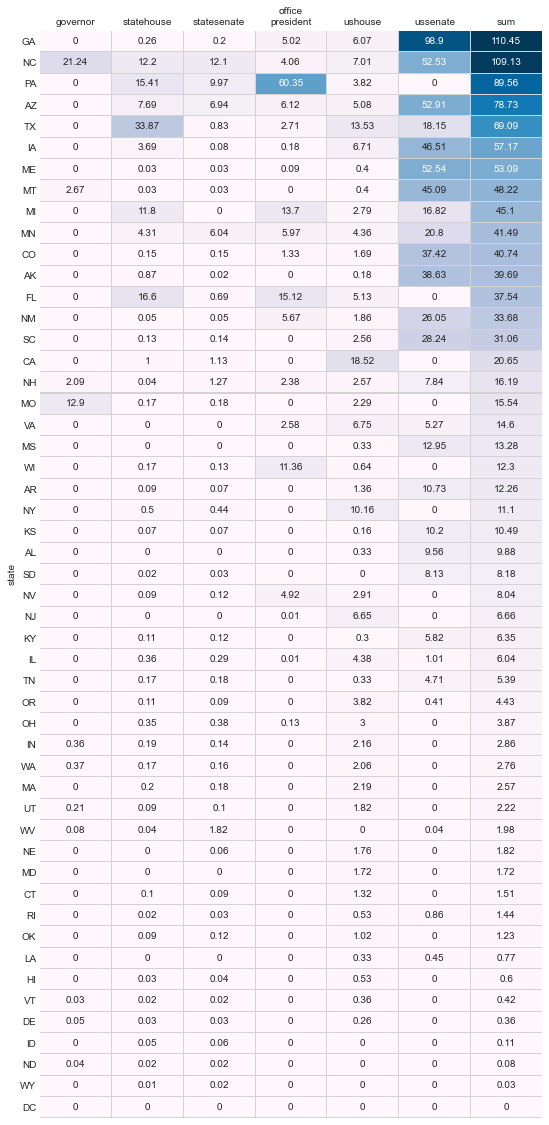

In [46]:
#http://seaborn.pydata.org/generated/seaborn.heatmap.html
fig, ax = plt.subplots(figsize=[9, 20]) #[7, 20] [20, 7] .T edgecolor='gray'
heatmap = sns.heatmap(np.around(matrix, decimals=2) , ax=ax, annot=True,fmt='g', linewidths=0.01, linecolor='lightgray',
    cbar=False, cmap='PuBu') #cmap="YlOrRd"  viridis 'cividis' YlGnBu Blues  best: OrRd PuBu
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
loc, labels = plt.yticks()
heatmap.set_yticklabels(labels, rotation=0)
# for _, spine in heatmap.spines.items():
#     spine.set_visible(True)
plt.savefig('heatmap.png', bbox_inches='tight')
heatmap
# Make this, with state legislatures, except in d3.js
# then allow people to set the weights, then show a transition where
# the states change position.
# Then include the individual histograms and seat distributions w/uncertainty as well.

In [49]:
#!cp -vr data/output/ ~/Documents/projects/pstblog/psthomas.github.io/images/elections-meta/